# Saving embeddings

In [ ]:
import torch
import transformers

from tqdm import tqdm
import numpy as np

In [170]:
n = '''Bengali	High
Bhojpuri	Low
Indonesian	High
Plateau Malagasy	Low
Zulu	High
Swati	Low
'''
lang_names = n.split('\n')
s = '''ben_Beng
bho_Deva
ind_Latn
plt_Latn
zul_Latn
ssw_Latn
'''
languages_of_interest = s.split('\n')

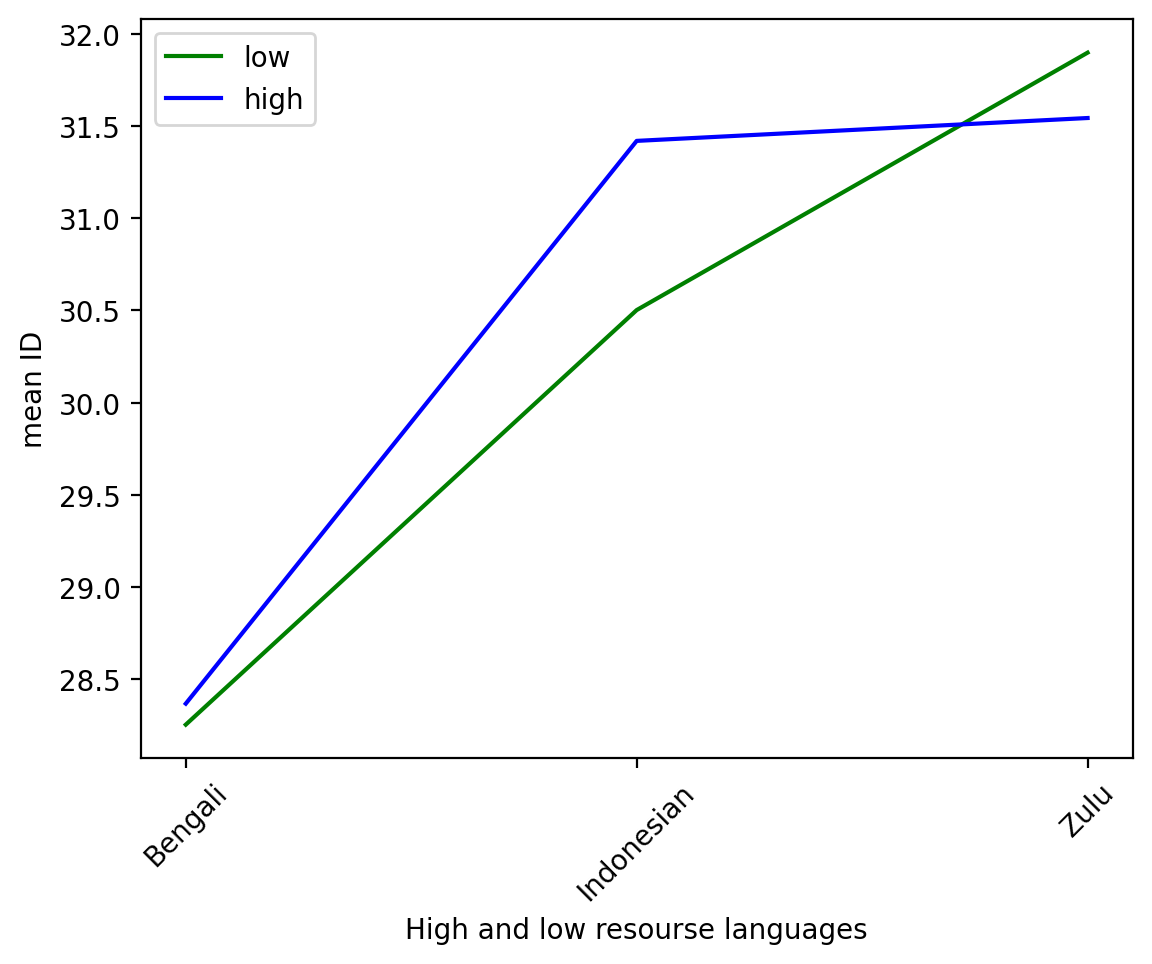

In [174]:
import json
import numpy as np
import matplotlib.pyplot as plt
with open('results/id_with_agg_res.json', 'r') as json_data:
    d = json.load(json_data)
lst = []
xt = []
for i in range(len(languages_of_interest)):
    lang = languages_of_interest[i]
    if lang not in d.keys():
        continue
    res = np.mean([d[lang][k] for k in d[lang].keys()])
    lst.append([res, lang_names[i]])
#lst = sorted(lst)
xth = [i[1] for i in lst if 'High' in i[1]]
xtl = [i[1] for i in lst if 'Low' in i[1]]
high = [i[0] for i in lst if 'High' in i[1]]
low = [i[0] for i in lst if 'High' not in i[1]]
plt.plot(low, color='green', label='low')
plt.plot(range(len(low)), high, color='blue', label='high')
plt.ylabel('mean ID')
plt.xlabel('High and low resourse languages')
plt.xticks(range(len(xtl)), labels=[i.split('\t')[0] for i in xth], rotation=45)
plt.legend()
plt.savefig('results/typ.png', bbox_inches='tight')
#plt.savefig("results/kl_no_agg_alph.png", format='png', dpi=600, bbox_inches='tight')

In [86]:
import os

def load_txt_files_to_dict(directory, filetype=".txt"):
    text_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(filetype):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text_dict[os.path.splitext(filename)[0]] = text.split("\n")
    return text_dict

def load_txt_files_to_dict__flores(directory):
    text_dict = {}
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            # Flores' files with text do not have the extension. The language is indicated after the dot symbol
            text_dict[os.path.splitext(filename)[1][1:]] = text.split("\n")
    return text_dict

In [87]:
data_dir = "floresp-v2.0-rc.3/dev"
dataset_texts = load_txt_files_to_dict__flores(data_dir)

In [89]:
n = '''Hebrew, Afro-Asiatic
Southern Sotho, Atlantic-Congo
Vietnamese, Austroasiatic
Tagalog, Austronesian
Basque, Basque
Hindi, Devanagari
Tosk Albanian, Indo-European
Macedonian, Indo-European
Icelandic, Indo-European
Greek, Indo-European
Bengali, Indo-European
Romanian, Indo-European
Japanese, Japonic
Korean, Koreanic
Chinese, Sino-Tibetan
Thai, Tai-Kadai
Northern Uzbek, Turkic
Estonian, Uralic
Finnish, Uralic'''
lang_names = n.split('\n')
s = '''heb_Hebr
sot_Latn
vie_Latn
tgl_Latn
eus_Latn
hin_Deva
als_Latn
mkd_Cyrl
isl_Latn
ell_Grek
ben_Beng
ron_Latn
jpn_Jpan
kor_Hang
zho_Hans
tha_Thai
uzn_Latn
est_Latn
fin_Latn'''
languages_of_interest = s.split('\n')

In [91]:
# Delete language keys in the dataset dict that are not present in the App. a at https://huggingface.co/microsoft/Phi-3.5-mini-instruct#appendix-a
languages_of_interest.append("eng_Latn")

iter_keys = list(dataset_texts.keys())
for key in iter_keys:
    if key not in languages_of_interest:
        del dataset_texts[key]

In [92]:
[(k, len(v)) for k, v in dataset_texts.items()]

[('min_Arab', 998),
 ('arb_Latn', 998),
 ('ace_Latn', 998),
 ('eng_Latn', 998),
 ('taq_Latn', 998),
 ('knc_Arab', 998),
 ('knc_Latn', 998),
 ('taq_Tfng', 998),
 ('ace_Arab', 998),
 ('arb_Arab', 998),
 ('min_Latn', 998)]

In [93]:
from transformers.trainer_pt_utils import LengthGroupedSampler
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def data_collator(examples, padding_value=0, max_length=2048):
    def trim_and_pad(seq, batch_first, padding_value):
        return pad_sequence([s[:max_length] for s in seq], batch_first=True, padding_value=padding_value)

    padding_value = tokenizer.pad_token_id or padding_value

    input_ids = trim_and_pad(
        [torch.tensor(example["input_ids"], dtype=torch.int32) for example in examples],
        batch_first=True,
        padding_value=padding_value,
    )
    corpus_ids = torch.stack([torch.tensor(example["corpus_id"], dtype=torch.int32) for example in examples])

    return dict(input_ids=input_ids, corpus_ids=corpus_ids, attention_mask=input_ids.ne(padding_value))

In [94]:
def get_first_level_layer_names(model):
    first_level_layers = ["embed_tokens"]
    for name, module in model.named_modules():
        if name.count(".") == 2:
            first_level_layers.append(name.split(".", 1)[1])
    return first_level_layers

In [95]:
def wrap_outputs_to_dict(outputs, batch, layer_names):
    # Length of non-pad elems to not save embeddings for padding tokens
    batch_lengths = batch["attention_mask"].sum(1)

    listed_hidden_states = []
    outputs.hidden_states = outputs.hidden_states
    for hidden_state_tensor in outputs.hidden_states:
        listed_hidden_state_tensor = {
            batch["corpus_ids"][i]: hidden_state_tensor[i, : batch_lengths[i]] for i in range(len(hidden_state_tensor))
        }
        listed_hidden_states.append(listed_hidden_state_tensor)
    hidden_state_tensors = {}
    for i, hidden_state in enumerate(listed_hidden_states):
        for idx, tensor in hidden_state.items():
            hidden_state_tensors["-".join([str(idx.numpy()), layer_names[i]])] = tensor.detach().cpu()
    return hidden_state_tensors

In [96]:
from safetensors import safe_open
from safetensors.torch import save_file
import gc


def process_and_save_embeddings(model, model_id, dataloader, current_lang):
    model_dir = model_id.split("/")[1]
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    filename = f"{model_dir}/{current_lang}.st"
    if f"{current_lang}.st" in os.listdir(model_dir):
        print(current_lang, 'done')
        return None
        
    torch.cuda.empty_cache()
    layer_names = get_first_level_layer_names(model)
    keys = ["attention_mask", "corpus_ids"]

    hidden_state_tensors = {}
    for batch in tqdm(dataloader, leave=True):
        info_data = {k: batch[k] for k in keys}

        input_ids = batch["input_ids"].to(device=device)
        attention_mask = batch["attention_mask"].to(device=device)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # in place 'or' operation
        hidden_state_tensors |= wrap_outputs_to_dict(output, info_data, layer_names)


    # This is going to be num_layers * batch_size
    print(current_lang, len(hidden_state_tensors))

    filename = f"{model_dir}/{current_lang}.st"
    save_file(hidden_state_tensors, filename)

    for _ in range(2):
        torch.cuda.empty_cache()
        gc.collect()

    return hidden_state_tensors

In [98]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda:1"
model_names = [
    # "ai-forever/mGPT",
    # "gradientai/Llama-3-8B-Instruct-Gradient-1048k",
    # "mistralai/Mistral-7B-Instruct-v0.3",
    # Proj 34
    # "Qwen/Qwen2-0.5B-Instruct"
    "microsoft/Phi-3.5-mini-instruct"
]

for model_id in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    # tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}
    tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        # attn_implementation="flash_attention_2", # not for V100
        use_cache=False,
        torch_dtype=torch.bfloat16,
        device_map=device,
    )

    model_dir = model_id.split("/")[1]
    batch_size = 16

    for current_lang in (tokenized_texts.keys()):
        filename = f"{model_dir}/{current_lang}.st"

        # if os.path.exists(filename):
        #     continue

        current_dataset = [
            {"input_ids": input_ids, "corpus_id": i}
            for i, input_ids in enumerate(tokenized_texts[current_lang]["input_ids"])
        ]

        current_sampler = LengthGroupedSampler(
            dataset=current_dataset,
            batch_size=batch_size,
        )

        current_loader = DataLoader(
            current_dataset,
            collate_fn=data_collator,
            sampler=current_sampler,
            batch_size=batch_size,
            shuffle=False,
        )

        hidden_state_tensors = process_and_save_embeddings(model, model_id, current_loader, current_lang)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [100]:
tokenized_texts.keys()

dict_keys(['min_Arab', 'arb_Latn', 'ace_Latn', 'eng_Latn', 'taq_Latn', 'knc_Arab', 'knc_Latn', 'taq_Tfng', 'ace_Arab', 'arb_Arab', 'min_Latn'])

# Calculating Metrics

In [105]:
import torch
import transformers

from tqdm import tqdm
import numpy as np
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [106]:
import os

def load_txt_files_to_dict(directory):
    text_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text_dict[os.path.splitext(filename)[0]] = text.split("\n")
    return text_dict

In [107]:
[(k, len(v)) for k, v in dataset_texts.items()]

[('min_Arab', 998),
 ('arb_Latn', 998),
 ('ace_Latn', 998),
 ('eng_Latn', 998),
 ('taq_Latn', 998),
 ('knc_Arab', 998),
 ('knc_Latn', 998),
 ('taq_Tfng', 998),
 ('ace_Arab', 998),
 ('arb_Arab', 998),
 ('min_Latn', 998)]

In [108]:
def unfold_dict(d, keep_ids=None):
    hierarchical = {}
    keep_ids = set(keep_ids) if keep_ids is not None else set()
    for key, value in tqdm(d.items()):
        sentence_id, layer = key.split("-")
        if layer not in hierarchical:
            hierarchical[layer] = {}
        if int(sentence_id) in keep_ids:
            hierarchical[layer][sentence_id + "_full"] = value
        hierarchical[layer][sentence_id] = value#.mean(0, keepdims=True)
    return hierarchical

In [109]:
dataset_texts.keys()

dict_keys(['min_Arab', 'arb_Latn', 'ace_Latn', 'eng_Latn', 'taq_Latn', 'knc_Arab', 'knc_Latn', 'taq_Tfng', 'ace_Arab', 'arb_Arab', 'min_Latn'])

In [110]:
from tqdm.auto import tqdm
from safetensors import safe_open
from safetensors.torch import save_file

hidden_states = {}

for language in dataset_texts.keys():
    filename = f"{model_dir}/{language}.st"
    hidden_states[language] = {}
    with safe_open(filename, framework="pt", device="cpu") as f:
        for key in f.keys():
            hidden_states[language][key] = f.get_tensor(key)
        hidden_states[language] = unfold_dict(hidden_states[language])

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

In [111]:
len(sorted(list(hidden_states.keys()))), \
sorted(list(hidden_states.keys())), 

(11,
 ['ace_Arab',
  'ace_Latn',
  'arb_Arab',
  'arb_Latn',
  'eng_Latn',
  'knc_Arab',
  'knc_Latn',
  'min_Arab',
  'min_Latn',
  'taq_Latn',
  'taq_Tfng'])

In [112]:
language_en = "eng_Latn"

# Load eng
if language_en not in hidden_states:
    filename = f"{model_dir}/{language}.st"
    hidden_states[language_en] = {}
    with safe_open(filename, framework="pt", device="cpu") as f:
        for key in f.keys():
            hidden_states[language_en][key] = f.get_tensor(key)
        hidden_states[language_en] = unfold_dict(hidden_states[language_en])

In [113]:
print(hidden_states[language_en]['embed_tokens']['0'].shape)
lst=[]
for k in hidden_states[language_en]['embed_tokens'].keys():
    lst.append(hidden_states[language_en]['embed_tokens'][k].shape[0])
print(max(lst), min(lst[:-1]))
len(hidden_states[language_en]['embed_tokens'])

hidden_states_en = hidden_states[language_en]
longest_sentence_id, longest_sentence_en = max(enumerate(hidden_states_en["embed_tokens"]), 
                                               key=lambda x: hidden_states_en["embed_tokens"][x[1]].shape[0])
print(longest_sentence_id, longest_sentence_en)
print(hidden_states_en["embed_tokens"][longest_sentence_en].shape)
longest_sentence = dataset_texts[language_en][longest_sentence_id]
print(longest_sentence)

torch.Size([58, 3072])
82 8
367 429
torch.Size([82, 3072])
Blood goes away from the heart in tubes called arteries and comes back to the heart in tubes called veins. The smallest tubes are called capillaries.


In [114]:
max_sent_length = -1
for lang in hidden_states.keys():
    max_sent_length = max(max_sent_length, 
                    max([hidden_states[lang]["embed_tokens"][key].shape[0] \
                         for key in hidden_states[lang]["embed_tokens"].keys()]))
print(max_sent_length)

604


In [115]:
import llm_microscope
import skdim

import numpy as np
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [116]:
for key in hidden_states.keys():
    break
list_layers = set(hidden_states[key].keys())
list_layers.remove("embed_tokens")
list_layers = list(list_layers)
list_layers.sort(key=lambda x: int(x.split(".")[1]))
list_layers = ["embed_tokens"] + list_layers
list_layers

['embed_tokens',
 'layers.0',
 'layers.1',
 'layers.2',
 'layers.3',
 'layers.4',
 'layers.5',
 'layers.6',
 'layers.7',
 'layers.8',
 'layers.9',
 'layers.10',
 'layers.11',
 'layers.12',
 'layers.13',
 'layers.14',
 'layers.15',
 'layers.16',
 'layers.17',
 'layers.18',
 'layers.19',
 'layers.20',
 'layers.21',
 'layers.22',
 'layers.23',
 'layers.24',
 'layers.25',
 'layers.26',
 'layers.27',
 'layers.28',
 'layers.29',
 'layers.30',
 'layers.31']

# Intrinsic dimensionality with aggregation

In [ ]:
import json
from collections import defaultdict
id_estimates = defaultdict(lambda: defaultdict(dict))

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        # sentence_emb = torch.cat([sentences[i] for i in idx])
        # for Qwen2-0.5 notebook only
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
        sentence_emb = torch.stack([sentences[i].mean(dim=0) for i in idx if len(sentences[i])!=0])
        id_estimator = skdim.id.TwoNN(discard_fraction=0.1)
        id_estimate = id_estimator.fit_transform(sentence_emb.to(dtype=float).numpy())
        id_estimates[language][layer] = id_estimate

with open('results/id_with_agg_typ.json', 'w') as fp:
    json.dump(id_estimates, fp)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(16,8))
lw=2
fs = 20
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Intrinsic Dimension", fontsize=fs)

mean_metric_list = []
length=len(languages_of_interest)
for i in range(length-1):
    language = languages_of_interest[i]
    if language not in list(hidden_states.keys()):
        continue
    name = lang_names[i]
    estimate = id_estimates[language]
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer])
    if isinstance(estimates[0], dict):
        continue
    mean_metric = np.mean(estimates)
    mean_metric_list.append(mean_metric)
    ls='solid'
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, linewidth=lw,
             linestyle=ls, label=f"{name}, mean ID={mean_metric:.2f}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("ID estimate", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), 
                            key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], 
           loc='upper center', bbox_to_anchor=(1.15, 1), fontsize=fs/3*2)
plt.savefig("results/id_with_agg_typ.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

# Anisotropy with aggregation

In [33]:
from collections import defaultdict
import torch
from scipy.sparse.linalg import svds
anisotropy_estimates = defaultdict(lambda: defaultdict(dict))

def calculate_anisotropy_torch(emb):
    embeddings = emb - emb.mean(dim=0, keepdim=True)
    num_iters = 70   
    x = torch.randn(embeddings.shape[0], device=embeddings.device, dtype=emb.dtype)
    for i in range(num_iters):    
        x /= torch.norm(x)
        x = x @ embeddings
        x /= torch.norm(x)
        x = embeddings @ x   
    sigma = torch.norm(x)
    anisotropy = sigma ** 2 / torch.norm(embeddings) ** 2    
    return anisotropy

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
        max_lang_sent_len = max([hidden_states[language]["embed_tokens"][key].shape[0] \
                         for key in hidden_states[language]["embed_tokens"].keys()])
        sentence_emb = torch.stack([sentences[i].mean(dim=0) for i in idx if len(sentences[i])!=0])
        anisotropy_estimate = calculate_anisotropy_torch(sentence_emb)
        anisotropy_estimates[language][layer] = anisotropy_estimate.to('cpu')

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

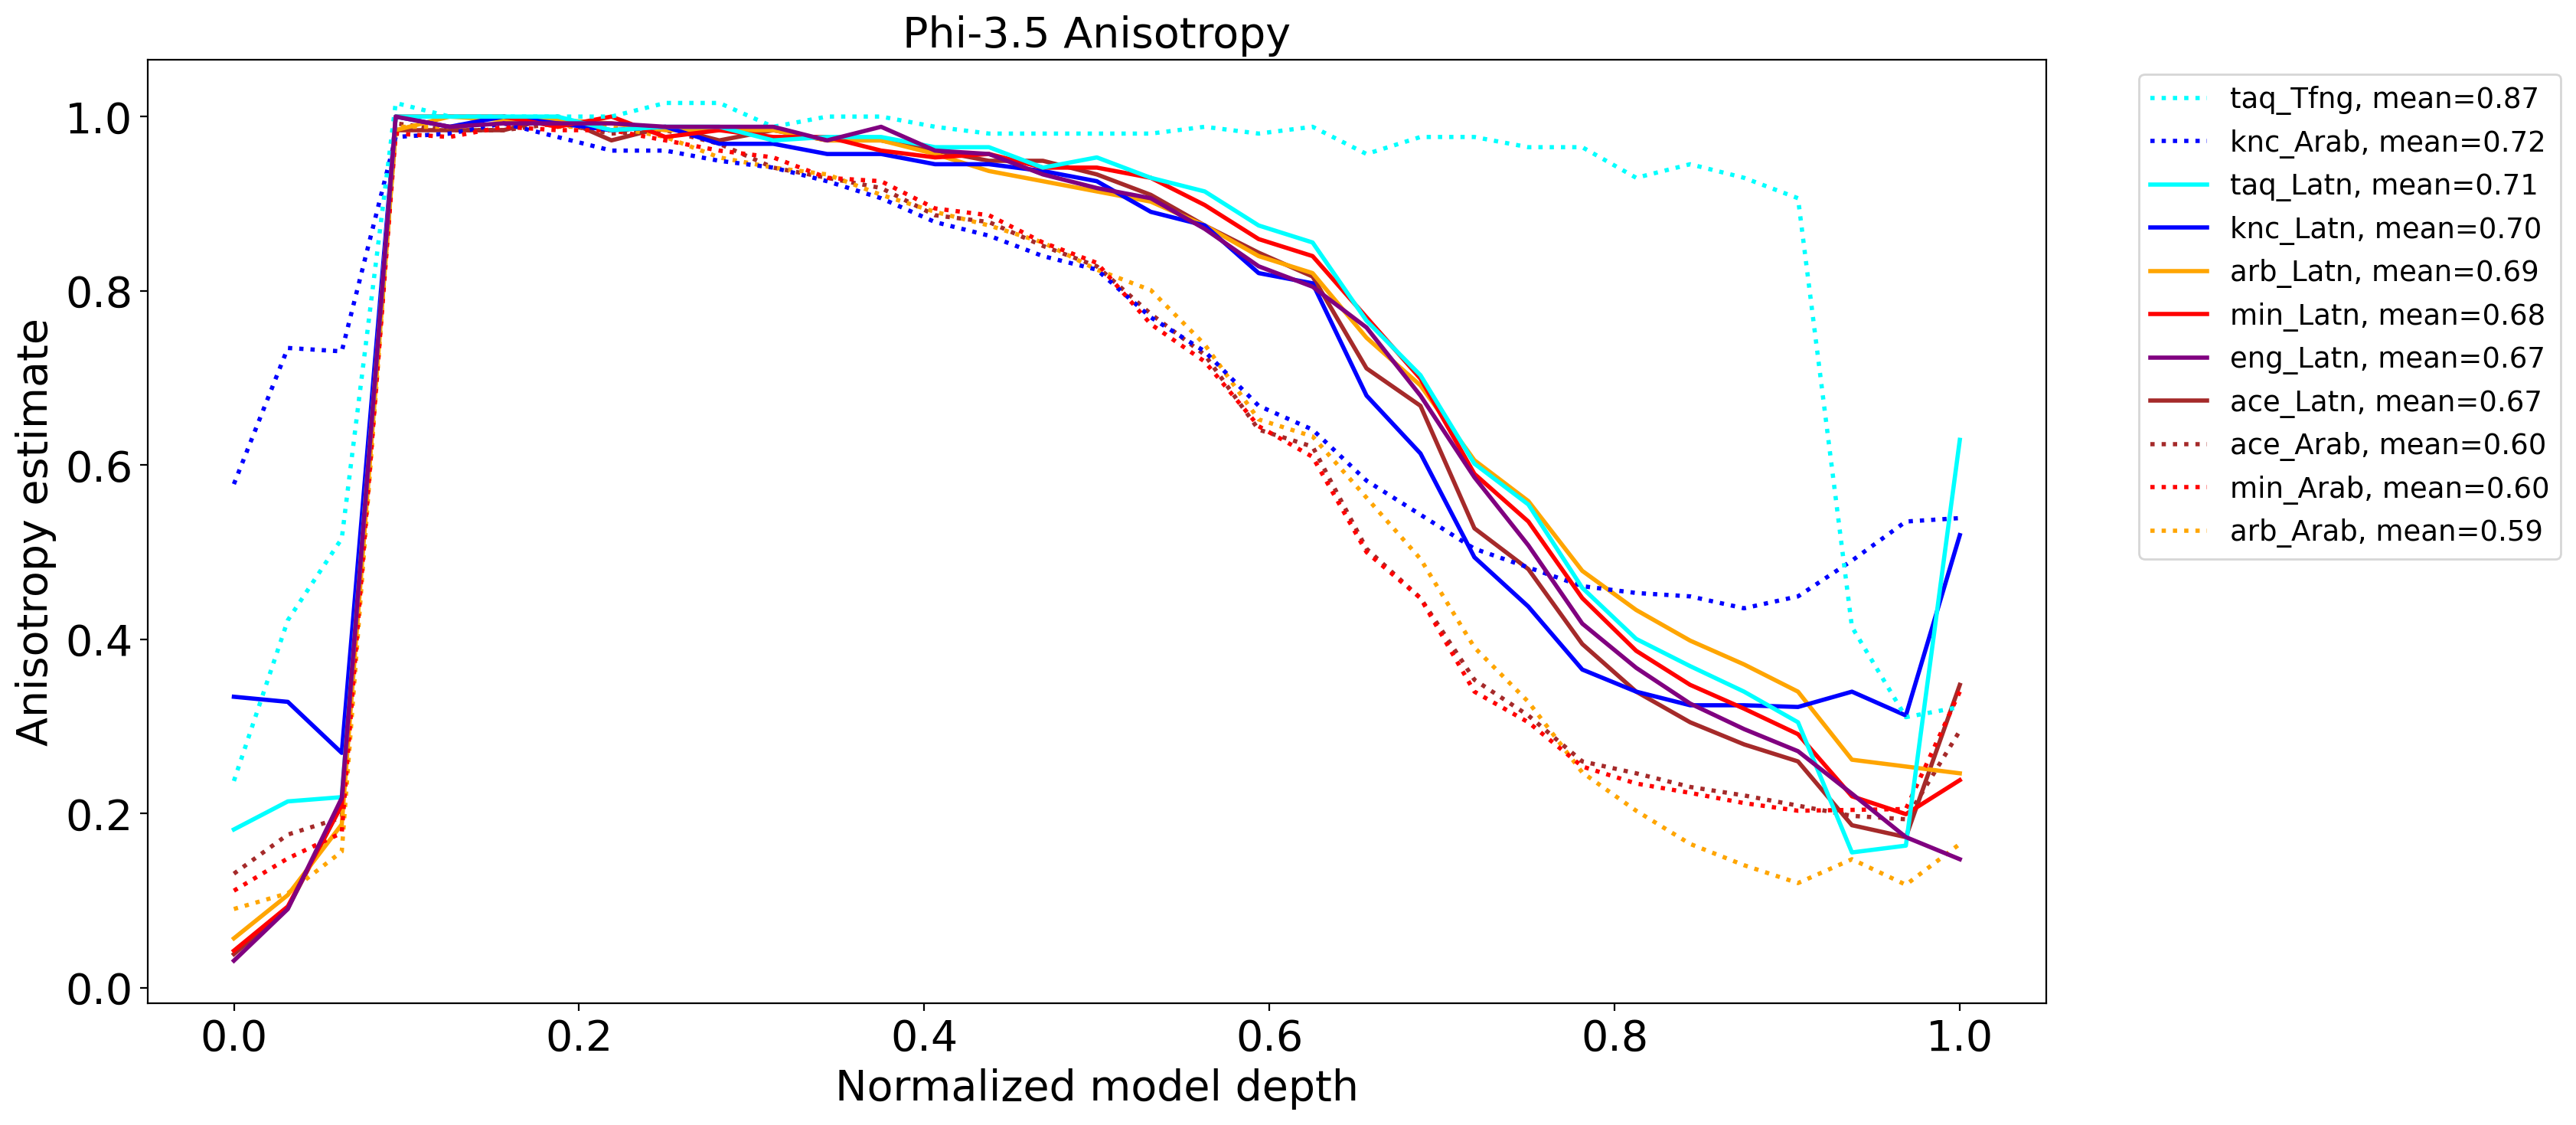

In [40]:
plt.figure(figsize=(16,8))
fs=20
lw=2
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Anisotropy", fontsize=fs)

mean_metric_list = []
length = len(languages_of_interest)
for i in range(length):
    language =  languages_of_interest[i]
    name = lang_names[i]
    estimate = anisotropy_estimates[language]
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer])
    if isinstance(estimates[0], dict):
        continue
    estimates=[float(i) for i in estimates]
    mean_metric = np.mean(estimates)
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, linewidth=lw, 
             label=f"{name}, mean={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("Anisotropy estimate", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], 
           loc='upper center', bbox_to_anchor=(1.16, 1), fontsize=fs/3*2)
plt.savefig("results/anisotropy_no_agg.png", format='png', dpi=600, bbox_inches='tight')

plt.show()

# Anisotropy without aggregation

In [310]:
from collections import defaultdict
import torch
from scipy.sparse.linalg import svds
anisotropy_estimates = defaultdict(lambda: defaultdict(dict))

def calculate_anisotropy_torch(emb):
    embeddings = emb - emb.mean(dim=0, keepdim=True) 
    num_iters = 70   
    x = torch.randn(embeddings.shape[0], device=embeddings.device, dtype=emb.dtype)
    for i in range(num_iters):     
        x /= torch.norm(x)
        x = x @ embeddings
        x /= torch.norm(x)
        x = embeddings @ x   
    sigma = torch.norm(x)
    anisotropy = sigma ** 2 / torch.norm(embeddings) ** 2    
    return anisotropy

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
        max_lang_sent_len = max([hidden_states[language]["embed_tokens"][key].shape[0] \
                         for key in hidden_states[language]["embed_tokens"].keys()])
        sentence_emb = torch.stack([torch.nn.functional.pad(sentences[i], (0, 0, 0, max_lang_sent_len-sentences[i].shape[0]),  
                                         value=0.0) for i in idx if len(sentences[i])!=0])
        anisotropy_estimate = sum([calculate_anisotropy_torch(sentence_emb[j]) \
                                   for j in range(sentence_emb.shape[0])]) / sentence_emb.shape[0]
        anisotropy_estimates[language][layer] = anisotropy_estimate.to('cpu')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

dict_keys(['embed_tokens', 'layers.0', 'layers.1', 'layers.10', 'layers.11', 'layers.12', 'layers.13', 'layers.14', 'layers.15', 'layers.16', 'layers.17', 'layers.18', 'layers.19', 'layers.2', 'layers.20', 'layers.21', 'layers.22', 'layers.23', 'layers.24', 'layers.25', 'layers.26', 'layers.27', 'layers.28', 'layers.29', 'layers.3', 'layers.30', 'layers.31', 'layers.4', 'layers.5', 'layers.6', 'layers.7', 'layers.8', 'layers.9'])


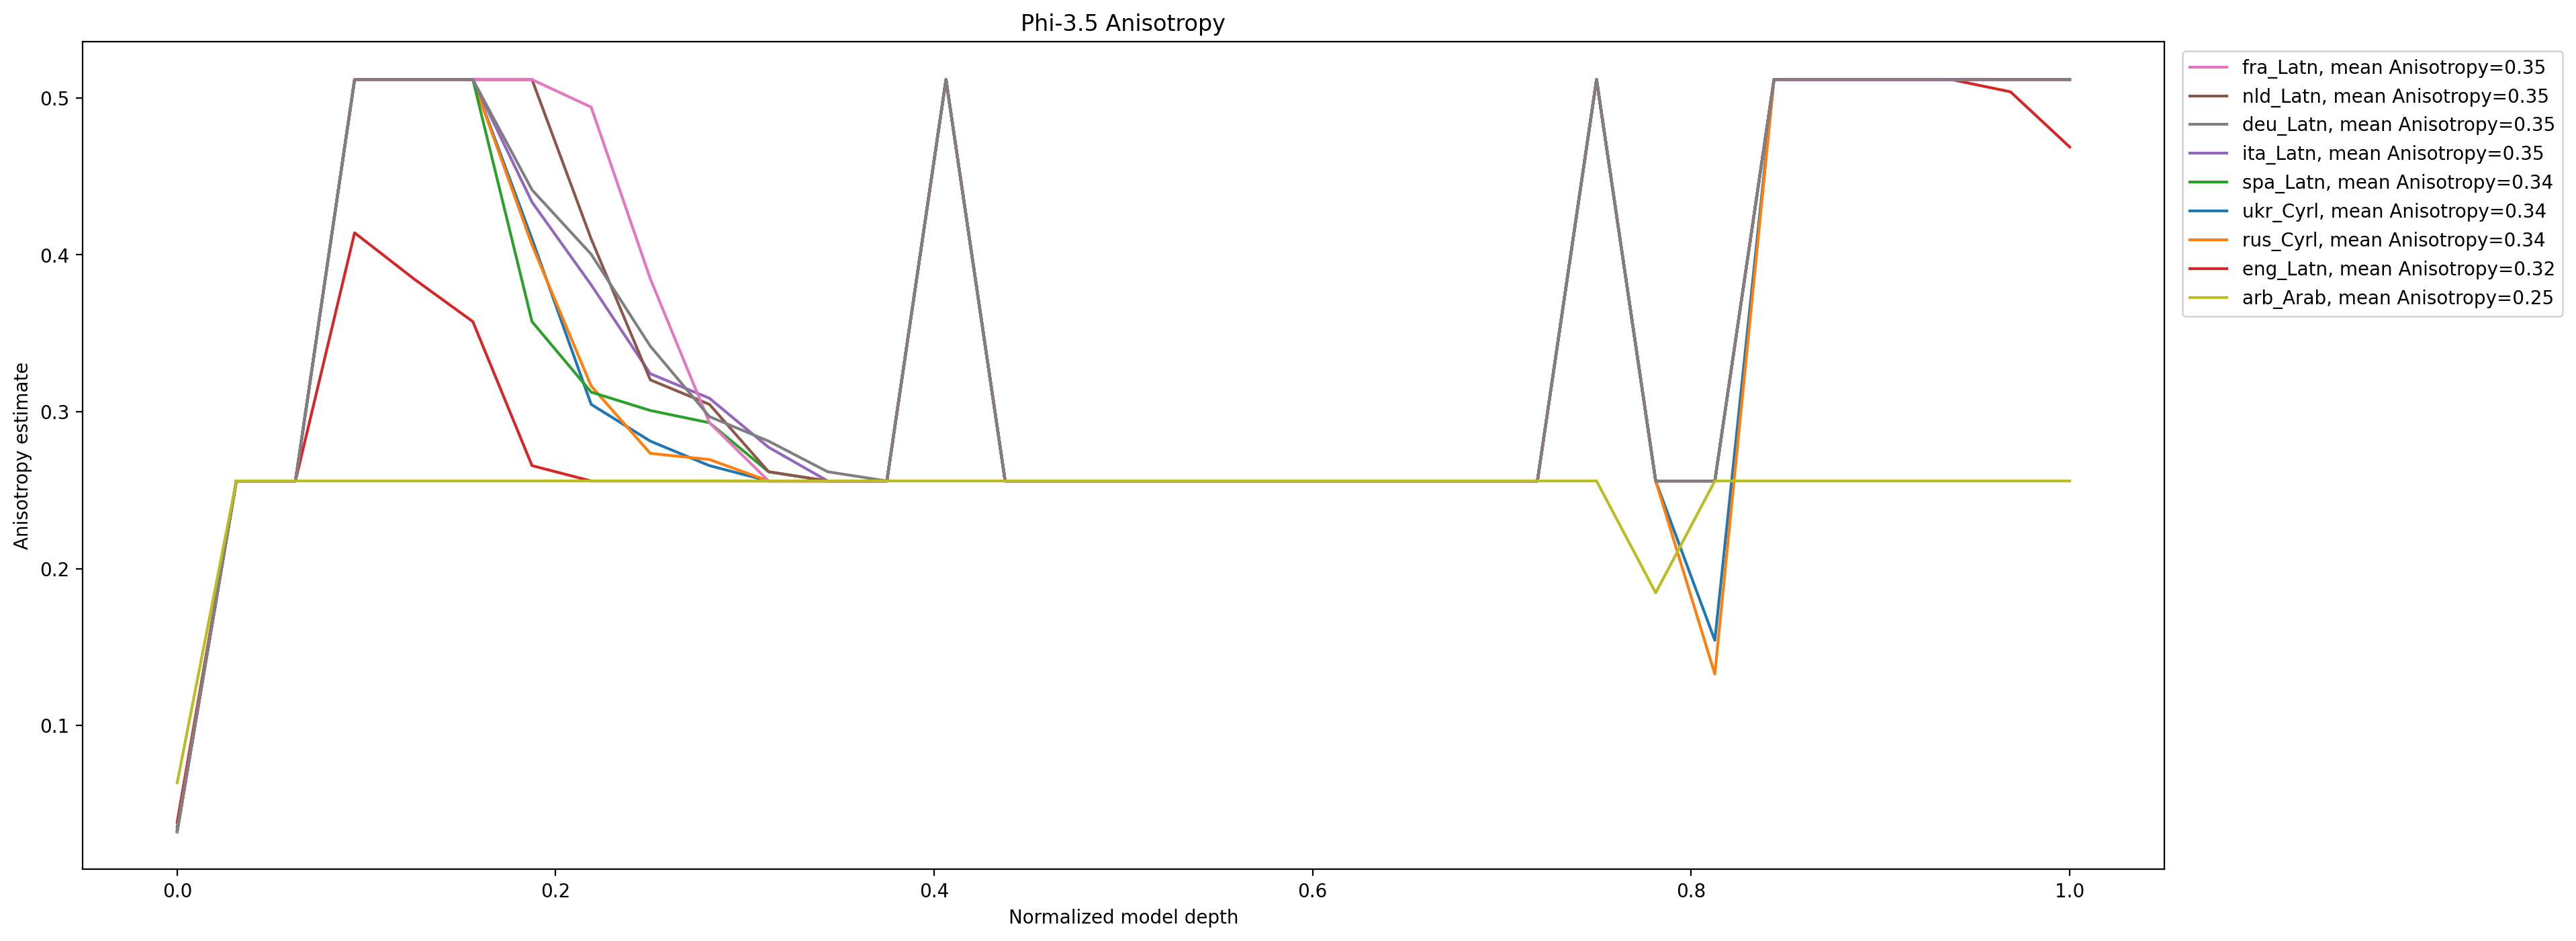

In [315]:
plt.figure(figsize=(16,8))
fs=20
lw=2
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Anisotropy", fontsize=fs)

mean_metric_list = []
length = len(languages_of_interest)
for i in range(length):
    language =  languages_of_interest[i]
    name = lang_names[i]
    estimate = anisotropy_estimates[language]
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer])
    if isinstance(estimates[0], dict):
        continue
    estimates=[float(i) for i in estimates]
    mean_metric = np.mean(estimates)
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, linewidth=lw, 
             label=f"{name}, mean={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("Anisotropy estimate", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], 
           loc='upper center', bbox_to_anchor=(1.16, 1), fontsize=fs/3*2)
plt.savefig("results/anisotropy_with_agg.png", format='png', dpi=600, bbox_inches='tight')

plt.show()

# KL divergence with aggregation

In [117]:
from collections import defaultdict
import torch
import torch.nn.functional as F
kl_agg_estimates = defaultdict(lambda: defaultdict(dict))
sentence_eng_emb = defaultdict()

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    if language=='eng_Latn':
        for layer, sentences in tqdm(hidden_state.items(), leave=False):
            sentence_eng_emb[layer] = torch.stack([sentences[i].mean(dim=0) for i in idx if len(sentences[i])!=0])
for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
        sentence_emb = torch.stack([sentences[i].mean(dim=0) for i in idx if len(sentences[i])!=0])
        kl_estimate = F.kl_div(F.log_softmax(sentence_eng_emb[layer], dim=1), F.softmax(sentence_emb, dim=1))
        kl_agg_estimates[language][layer] = kl_estimate.to('cpu')

KeyboardInterrupt: 

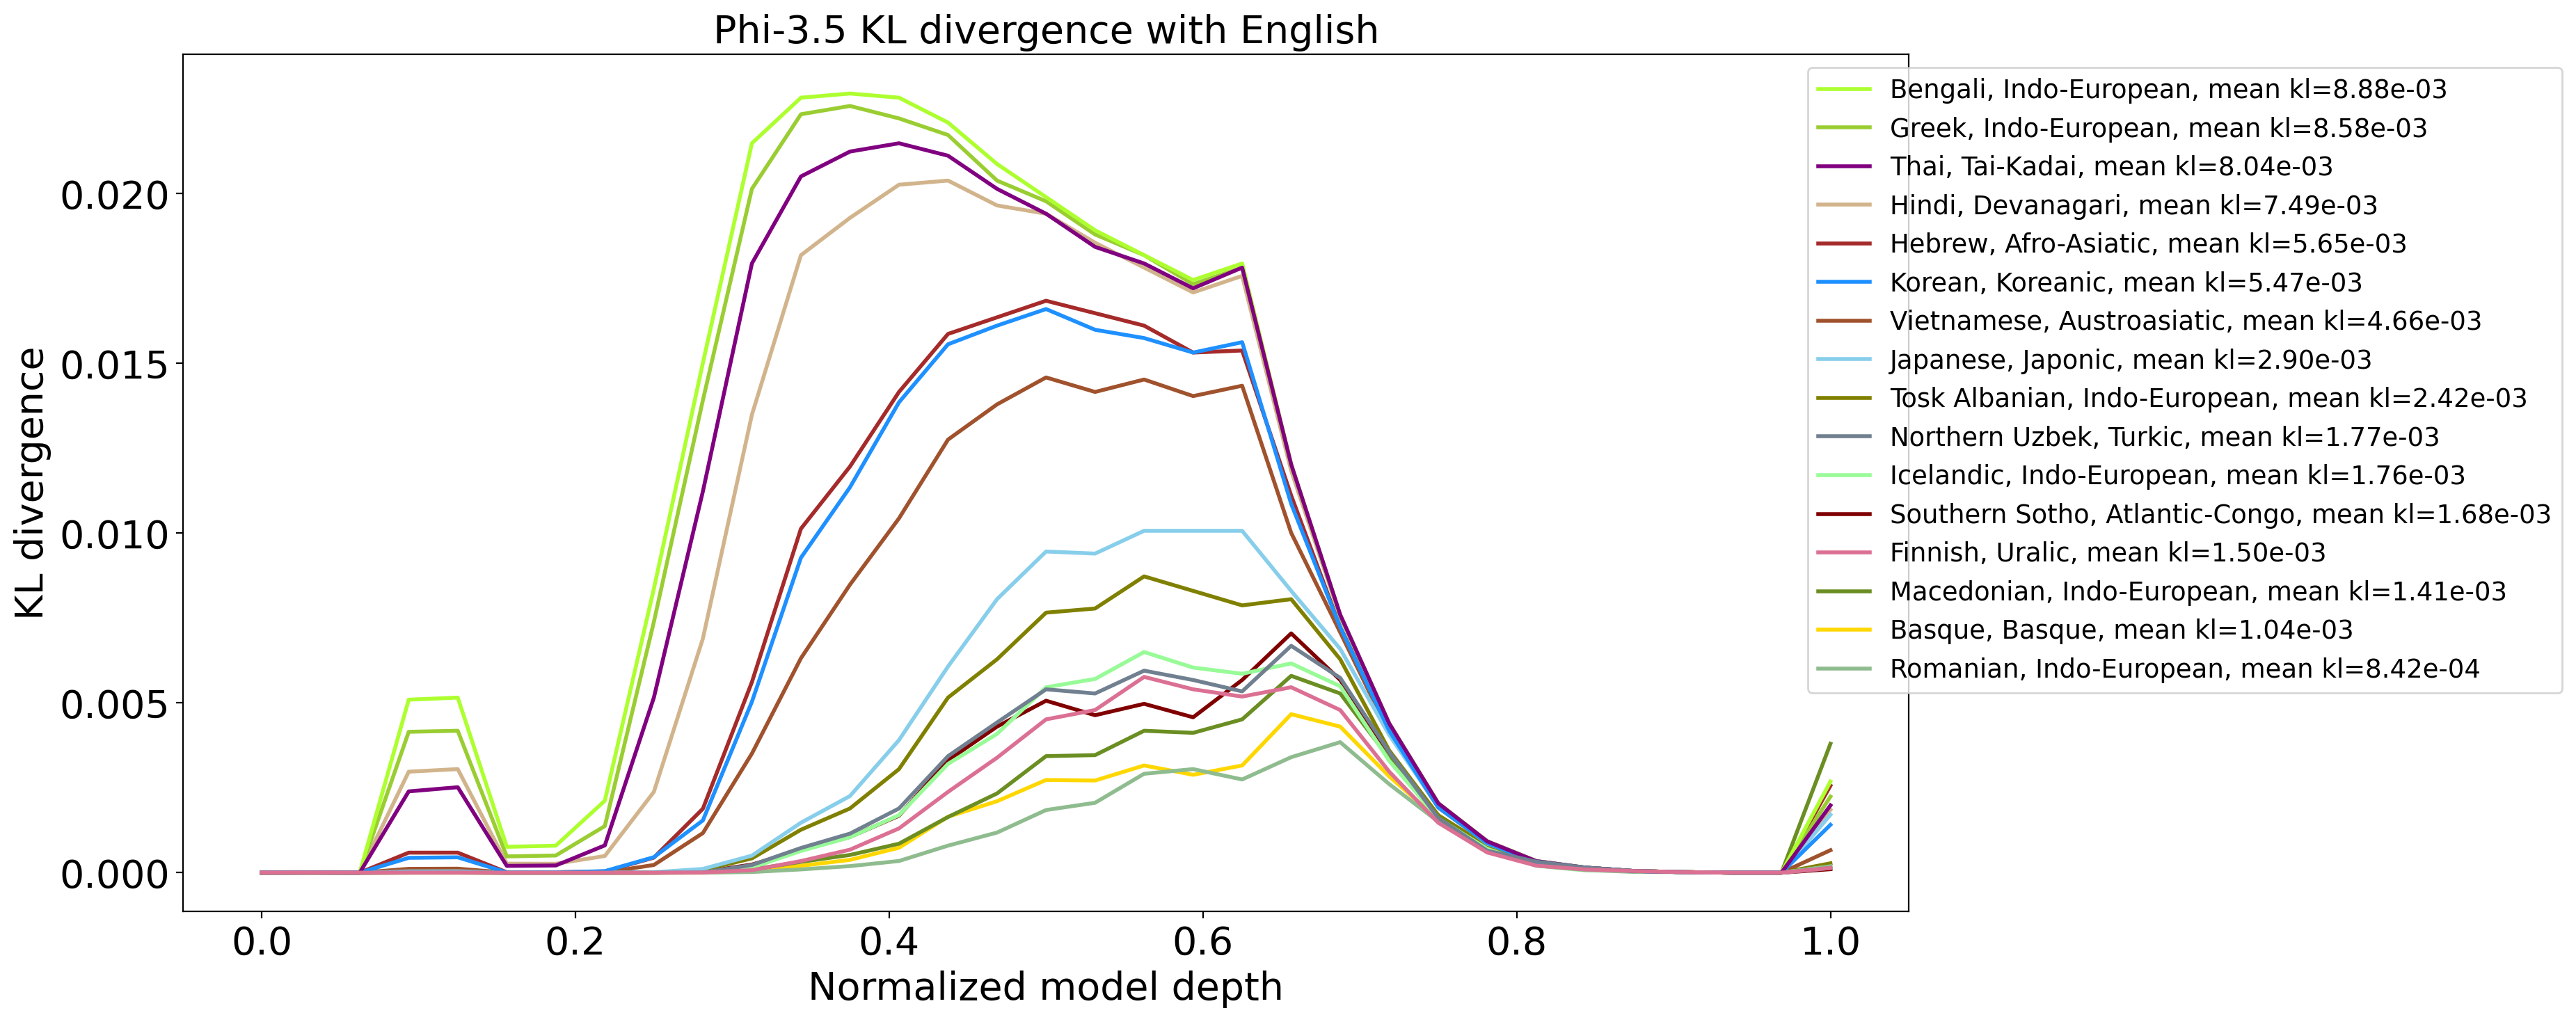

In [76]:
plt.figure(figsize=(16,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} KL divergence with English", fontsize=fs)

mean_metric_list = []

mean_metric_list = []
length=len(languages_of_interest)
for i in range(length):
    language = languages_of_interest[i]
    if language not in list(hidden_states.keys()):
        continue
    name = lang_names[i]
    estimate = kl_agg_estimates[language]
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer])
    if isinstance(estimates[0], dict):
        continue
    ls = 'solid'
    estimates=[float(i) for i in estimates]
    mean_metric = np.mean(estimates)
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, linewidth=lw,
             linestyle=ls, label=f"{name}, mean kl={np.mean(estimates):.2e}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("KL divergence", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], 
           loc='upper center', bbox_to_anchor=(1.16, 1), fontsize=fs/3*2)
plt.savefig("results/kl_agg_eng_other.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

# KL without aggregation

In [118]:
from collections import defaultdict
import torch
import torch.nn.functional as F
kl_no_agg_estimates = defaultdict(lambda: defaultdict(dict))
sentence_eng_emb = defaultdict()

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)
for language, hidden_state in tqdm(hidden_states.items()):
    if language=='eng_Latn':
        for layer, sentences in tqdm(hidden_state.items(), leave=False):
            sentence_eng_emb[layer] = torch.stack([torch.nn.functional.pad(sentences[i], 
                                        (0, 0, 0, max_sent_length-sentences[i].shape[0]),  
                                         value=0.0) for i in idx if len(sentences[i])!=0])
for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
        sentence_emb = torch.stack([torch.nn.functional.pad(sentences[i], 
                                    (0, 0, 0, max_sent_length-sentences[i].shape[0]),  
                                    value=0.0) for i in idx if len(sentences[i])!=0])
        kl_estimate = [F.kl_div(F.log_softmax(sentence_eng_emb[layer][j], dim=1), 
                                F.softmax(sentence_emb[j], dim=1)) for j in range(sentence_emb.shape[0])]
        kl_estimate = torch.mean(torch.tensor(kl_estimate))
        kl_no_agg_estimates[language][layer] = kl_estimate.to('cpu')

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

KeyError: 'taq'

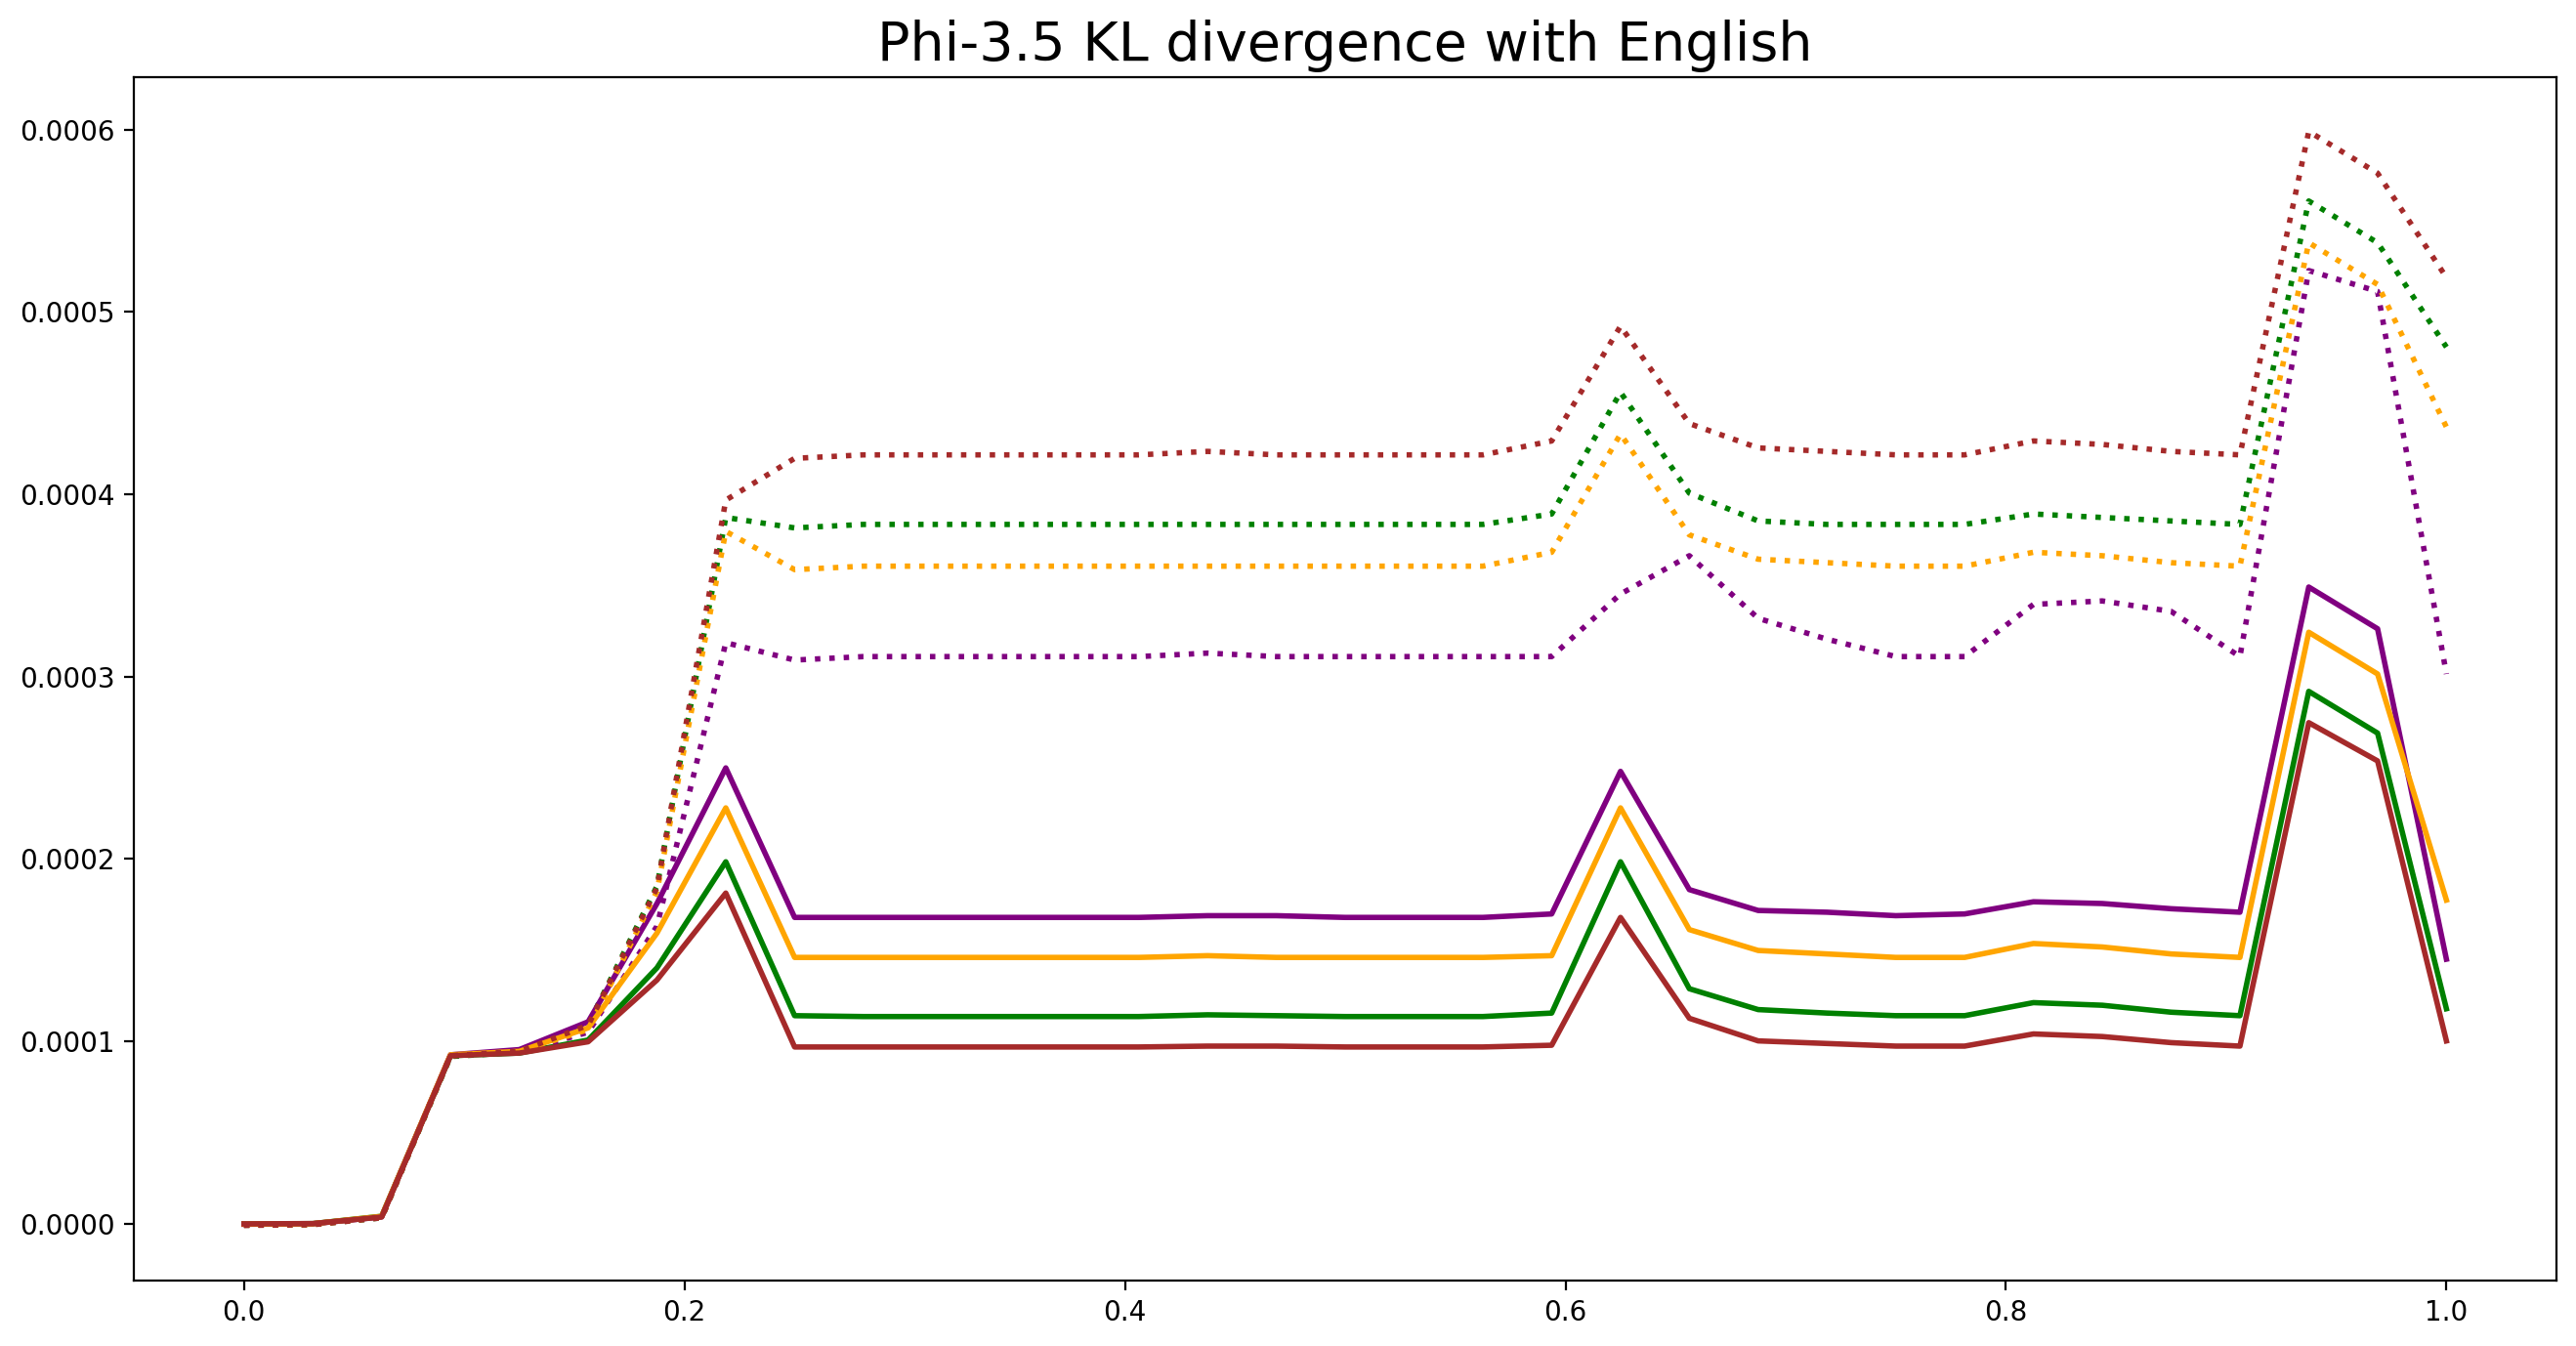

In [134]:
plt.figure(figsize=(16,8))
fs = 20
lw=2
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} KL divergence with English", fontsize=fs)

length = len(languages_of_interest)
mean_metric_list = []
for i in range(length):
    language = languages_of_interest[i]
    if language not in list(hidden_states.keys()):
        continue
    name = lang_names[i]
    estimate = kl_no_agg_estimates[language]
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer])
    if isinstance(estimates[0], dict):
        continue
    ls = 'solid'
    estimates=[float(i) for i in estimates]
    mean_metric = np.mean(estimates)
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates,
             label=f"{language}, mean kl={np.mean(estimates):.2e}", 
             linewidth=lw, linestyle=ls)
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("KL divergence", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], fontsize=fs, 
           loc='upper center', bbox_to_anchor=(1.21, 1))
plt.savefig("results/kl_no_agg_alph.png", format='png', dpi=600, bbox_inches='tight')
plt.show()